In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NADJIBATA-audio-genre-classification

/content/drive/MyDrive/NADJIBATA-audio-genre-classification


In [ ]:
# Correction automatique
import re

file_path = '/content/drive/MyDrive/audio-genre-classification-wav2vec/src/train_baseline.py'

with open(file_path, 'r') as f:
    content = f.read()

# Supprimer verbose=True
content = content.replace(', verbose=True)', ')')

with open(file_path, 'w') as f:
    f.write(content)

print("✅ Fichier corrigé!")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/audio-genre-classification-wav2vec/src/train_baseline.py'

In [ ]:
!python src/train_baseline.py

🔧 Device utilisé: cuda
🎵 BASELINE CNN - GTZAN MUSIC GENRE CLASSIFICATION

🔧 Correction des chemins pour Linux/Colab...
   ✅ Chemins corrigés


📂 1. Chargement des datasets...
   Dataset chargé: 699 fichiers
   Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
   Dataset chargé: 150 fichiers
   Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
   Dataset chargé: 150 fichiers
   Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
   ✅ Label encoder sauvegardé

🏗️  2. Construction du modèle...
   🏗️  Construction du modèle avec Global Average Pooling...
   ✅ Total paramètres: 654,282
   ✅ Paramètres entraînables: 654,282
   Total paramètres: 654,282
   Paramètres entraînables: 654,282

🏋️  3. Entraînement...

Epoch 1/100
Train Loss: 2.1235 | Train Acc: 18.88%
Val Loss: 3.1161 | Val Acc: 10.00%
   ✅ Meilleur modèle sauvegardé

Epoch 2/100
Train Loss: 1.817

✅ Modèle chargé et prêt pour l'évaluation.


100%|██████████| 19/19 [00:09<00:00,  2.02it/s]


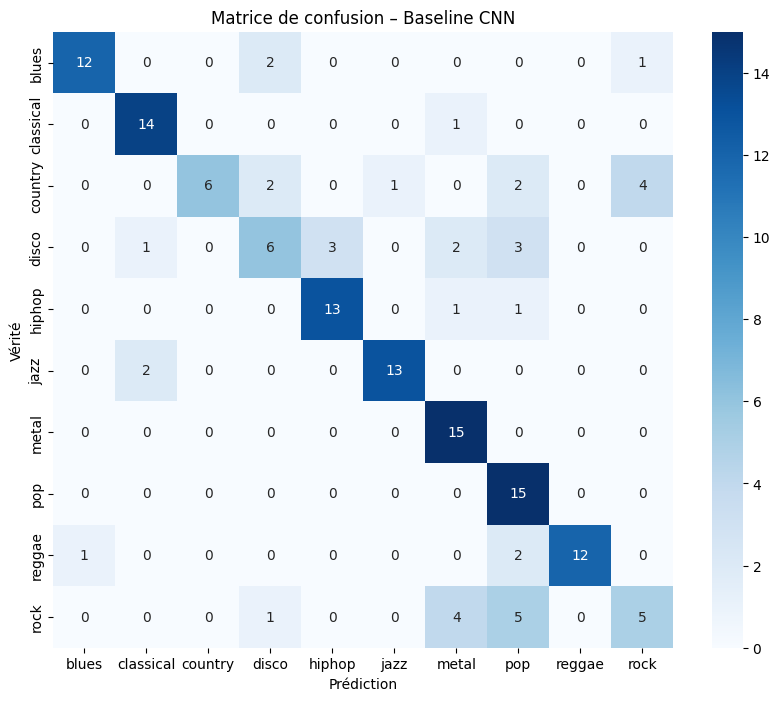

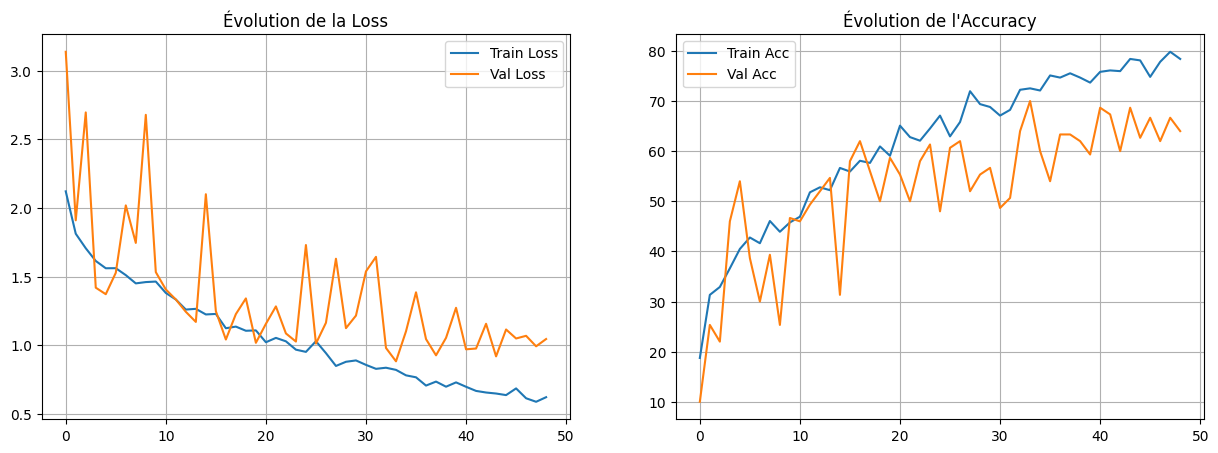

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import librosa
from torch.utils.data import Dataset, DataLoader


# ---------------------------------------------------------
# 1. Recharger l'architecture du modèle (TA MÊME CLASSE CNN)
# ---------------------------------------------------------

class MusicGenreCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# ---------------------------------------------------------
# 2. Charger le modèle sauvegardé
# ---------------------------------------------------------

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = torch.load(
    "/content/drive/MyDrive/NADJIBATA-audio-genre-classification/models/wav2vec/baseline/best_model.pth",
    map_location=DEVICE
)

# *******************************************************************
# IMPORTANT → On doit recréer le modèle avant de charger le state_dict
# *******************************************************************

# Charger le label_encoder pour connaître le nombre de classes
with open("/content/drive/MyDrive/NADJIBATA-audio-genre-classification/models/wav2vec/baseline/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)

model = MusicGenreCNN(num_classes=num_classes).to(DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("✅ Modèle chargé et prêt pour l'évaluation.")

# ---------------------------------------------------------
# 3. Dataset test pour l'évaluation
# ---------------------------------------------------------


class GTZANDatasetInfer(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]["filepath"].replace("\\", "/")

        # Mel spectrogram identique à ton entraînement
        y, sr = librosa.load(path, sr=22050, duration=30)
        target_length = 22050 * 30
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)))
        else:
            y = y[:target_length]

        mel = librosa.feature.melspectrogram(
            y=y, sr=sr,
            n_mels=128, n_fft=2048, hop_length=512
        )
        mel = librosa.power_to_db(mel, ref=np.max)
        mel = (mel - mel.min()) / (mel.max() - mel.min())

        return torch.tensor(mel).unsqueeze(0).float(), self.df.iloc[idx]["genre"]


test_dataset = GTZANDatasetInfer("data/splits/test.csv")
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---------------------------------------------------------
# 4. Prédiction sur test
# ---------------------------------------------------------

y_true = []
y_pred = []

with torch.no_grad():
    for X, labels in tqdm(test_loader):
        X = X.to(DEVICE)
        outputs = model(X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(label_encoder.transform(labels))

# ---------------------------------------------------------
# 5. Matrice de confusion
# ---------------------------------------------------------

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap="Blues")
plt.title("Matrice de confusion – Baseline CNN")
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.show()

# ---------------------------------------------------------
# 6. Courbes Loss / Accuracy
# ---------------------------------------------------------

with open("/content/drive/MyDrive/NADJIBATA-audio-genre-classification/models/wav2vec/baseline/training_history.pkl", "rb") as f:
    history = pickle.load(f)

plt.figure(figsize=(15, 5))

# Courbe Loss
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Évolution de la Loss")
plt.legend()
plt.grid()

# Courbe Accuracy
plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Évolution de l'Accuracy")
plt.legend()
plt.grid()

plt.show()
